In [1]:
from setup import proj_dir, out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

from collections import OrderedDict
import os


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms

import glob
import pickle as pkl

from dataloader import image_loader
from M1_util_train_test import load_model
from util_image import inverse_transform


In [10]:
model_type = 'AE'
load_model_name = 'Autoencoder_raw'
load_model_file = 'ae'
zoomlevel = 'zoom13_bilateral'
output_dim = 1
model_run_date = '220118'

variable_names = ['trpgen','active','auto','mas','pt']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

In [11]:
args = {'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':len(demo_variables),
       'cardinality':1,
       'epochs':20,
       'batch_size':16,
       'base_lr':0.1,
       'weight_decay':0.0005,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[150,225]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':False}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

# Load Model

In [12]:
# Check one model exists for this config
model_path = glob.glob(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                       model_run_date+"_*.pt")
#
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"
                      +model_run_date+"_*.pt")

/dream/qingyi/image_chicago/models/AE_zoom13_bilateral_2048_220118_60.pt loaded.


In [13]:
# load model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config['model_config'])

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('autoencoder',load_model_name, config)
model.load_state_dict(saved['model_state_dict']);

In [7]:
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], run_config['num_workers'], 
                                         data_config['image_size'], recalculate_normalize=False)


# Encoder Embeddings

In [14]:
# Check if embeddings have been saved
files = glob.glob(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                       model_run_date+".pkl")

if len(files) == 1:
    with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f:
        encoder_output = pkl.load(f)
        im = pkl.load(f)
        ct = pkl.load(f)
        
elif len(files) > 1:
    print("Multiple Files exist. Check specified path.")
    
else: # Calculate Embedding
    ct = []
    encoder_output = []
    im = []

    for step, data in enumerate(train_loader):
        ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
        encoder_output += [encoder(data[1]).detach().numpy()]
        im += data[0]
        if step % 10 == 0:
            print(step, end='\t')

    for step, data in enumerate(test_loader):
        ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
        encoder_output += [encoder(data[1]).detach().numpy()]
        im += data[0]
        if step % 10 == 0:
            print(step, end='\t')

    encoder_output = np.vstack(encoder_output)    

    print(encoder_output.shape)
    encoder_output = encoder_output.reshape(len(encoder_output), -1)

    # Save Embeddings

    with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                           model_run_date+".pkl", "wb") as f:
        pkl.dump(encoder_output, f)
        pkl.dump(im, f)
        pkl.dump(ct, f)

0	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	240	250	260	270	280	290	300	310	320	330	340	350	360	370	380	390	400	410	0	10	20	30	40	(7410, 2048, 1, 1)


# Create perturbed epsilon around existing embeddings

In [16]:
n = 10

sample_embedding = encoder_output[:n, :]

from torchvision import transforms
for i in range(n): 
    decoder_in = torch.tensor(sample_embedding[i])
    epsilon = torch.normal(0, 0.0001, size = (1, 2048)).view(-1)
    decoder_in += epsilon
    
    decoder_in = decoder_in.view(1, -1, model_config['output_dim'], model_config['output_dim'])
    reconstruct = decoder(decoder_in)[0]
    reconstruct = inverse_transform(reconstruct)
    
    im = transforms.ToPILImage()(reconstruct).convert("RGB")
#     display(im)
    im.save(out_dir+"image_samples/latent_perturb/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+ct[i]+"_perturbation_reg.png")
    

In [12]:
from torchvision import transforms
for i in range(10): #len(aggregate_embeddings)):
    decoder_in = torch.tensor(aggregate_embeddings[i])
    decoder_in = decoder_in.view(1, -1, model_config['output_dim'], model_config['output_dim'])
    reconstruct = decoder(decoder_in)[0]
    im = transforms.ToPILImage()(reconstruct).convert("RGB")
#     display(im)
    im.save(out_dir+zoomlevel+"/"+str(model_config['output_dim']**2*2048)+"_"+unique_ct[i]+"_reg.png")
    

In [40]:
from sklearn import manifold
method = manifold.TSNE(n_components=2, init='pca', random_state=0)
#method = manifold.Isomap(n_neighbors=5, n_components=2)
t0 = time()
Y = method.fit_transform(encoder_output)
t1 = time()
print("%s: %.2g sec" % ('Time', t1 - t0))


Time: 7.9e+02 sec


In [131]:
len(set(np.unique(ct_shp['GEOID10'])).intersection(set(np.unique(Y_df['census_tract_11d']))))

238

In [132]:
ct_shp['GEOID10']

0      17031010100
1      17031010201
2      17031010202
3      17031010300
4      17031010400
          ...     
806    17031843700
807    17031843800
808    17031843900
809    17031980000
810    17031980100
Name: GEOID10, Length: 811, dtype: object

In [130]:
len(set(np.unique(Y_df['census_tract_11d']))

925

In [134]:
len(np.unique(ct_df.loc[ct_df['county_fips_1'] == 31, 'census_tract']))

449

In [39]:
Y.shape

(17310, 17310)

In [136]:
len(np.unique(Y_df['county_fips_1']))

14

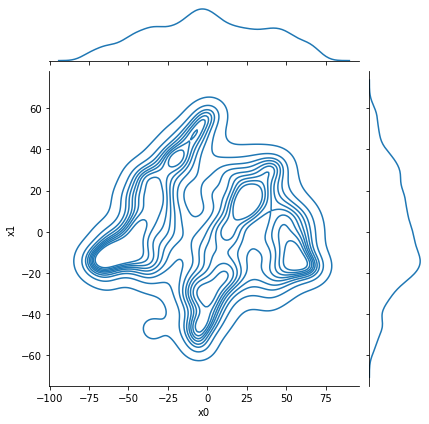

In [47]:
# SW visualizes the latent space. 
import seaborn as sns

Y_df = pd.DataFrame(Y, columns = ['x0', 'x1'])
Y_df['census_tract_y'] = ct
Y_df = pd.concat([Y_df, ct_df], axis = 1)
# Y_df = Y_df.merge(ct_df, on = 'census_tract')
sns.jointplot(x=Y_df["x0"], y=Y_df["x1"], kind='kde') # Shape of Z space. 

# sns.kdeplot(data=Y_df, x='x0', y='x1')
# scatter plot
# sns.jointplot(x=Y_df["x0"], y=Y_df["x1"], kind='scatter')


In [28]:
Y_df

x0         x1   census_tract
0      47.861042  35.246555   17_31_823302
1      -2.249317 -17.083941   17_89_852905
2     -12.401425  33.111824  17_197_880113
3       7.471601 -34.985386   17_43_840202
4      -2.544742   2.280747   17_31_804714
...          ...        ...            ...
17305  48.569759 -13.173395  17_111_870812
17306   3.309313  54.440861  17_111_870812
17307 -10.557844 -20.130695  17_111_870812
17308  25.389475 -10.776248  17_111_870812
17309  25.587831 -31.361269  17_111_870812

[17310 rows x 3 columns]

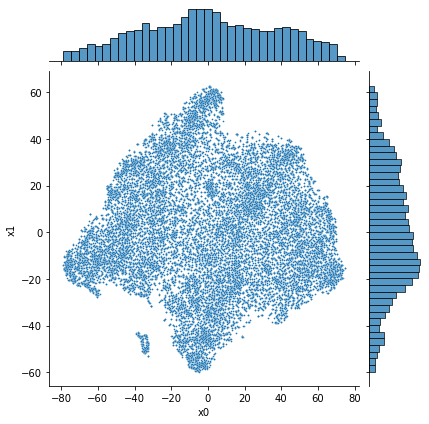

In [48]:
# scatter plot
sns.jointplot(x=Y_df["x0"], y=Y_df["x1"], kind='scatter', s = 3)

In [137]:
Y_df

x0         x1 census_tract_y   census_tract  tot_population  \
0      47.861042  35.246555   17_31_823302   17_31_823302          0.5979   
1      -2.249317 -17.083941   17_89_852905   17_89_852905          0.4522   
2     -12.401425  33.111824  17_197_880113  17_197_880113          0.3780   
3       7.471601 -34.985386   17_43_840202   17_43_840202          0.5839   
4      -2.544742   2.280747   17_31_804714   17_31_804714          0.3227   
...          ...        ...            ...            ...             ...   
17305  48.569759 -13.173395  17_111_870812  17_111_870812          0.4580   
17306   3.309313  54.440861  17_111_870812  17_111_870812          0.4580   
17307 -10.557844 -20.130695  17_111_870812  17_111_870812          0.4580   
17308  25.389475 -10.776248  17_111_870812  17_111_870812          0.4580   
17309  25.587831 -31.361269  17_111_870812  17_111_870812          0.4580   

       pct25_34yrs  pct35_50yrs  pctover65yrs  pctwhite_alone  pct_nonwhite  \
0         0.161064     0.155544      0.128282        0.532698      0.467302   
1         0.099071     0.235958      0.111676        0.509288      0.490712   
2         0.161905     0.199206      0.064021        0.311376      0.688624   
3         0.113889     0.146600      0.222127        0.881144      0.118856   
4         0.121475     0.259374      0.141927        0.747134      0.252866   
...            ...          ...           ...             ...           ...   
17305     0.104148     0.254585      0.084279        0.930568      0.069432   
17306     0.104148     0.254585      0.084279        0.930568      0.069432   
17307     0.104148     0.254585      0.084279        0.930568      0.069432   
17308     0.104148     0.254585      0.084279        0.930568      0.069432   
17309     0.104148     0.254585      0.084279        0.930568      0.069432   

       ...  inc_per_capita  state_1  state_fips_1  county_fips_1  \
0      ...        0.154593       IL            17             31   
1      ...        0.109373       IL            17             89   
2      ...        0.128963       IL            17            197   
3      ...        0.227644       IL            17             43   
4      ...        0.224752       IL            17             31   
...    ...             ...      ...           ...            ...   
17305  ...        0.219916       IL            17            111   
17306  ...        0.219916       IL            17            111   
17307  ...        0.219916       IL            17            111   
17308  ...        0.219916       IL            17            111   
17309  ...        0.219916       IL            17            111   

       tract_fips_1  mode  wtperfin_mode  wtperfin_all  mode_share  \
0            823302     2      6497.3341     7177.2929    0.905262   
1            852905     2      9887.9204    10483.9920    0.943145   
2            880113     2      9321.6444     9381.4312    0.993627   
3            840202     2      6880.2732     6880.2732    1.000000   
4            804714     2      6671.2959     7842.8961    0.850616   
...             ...   ...            ...           ...         ...   
17305        870812     2      6430.6895     7360.7037    0.873651   
17306        870812     2      6430.6895     7360.7037    0.873651   
17307        870812     2      6430.6895     7360.7037    0.873651   
17308        870812     2      6430.6895     7360.7037    0.873651   
17309        870812     2      6430.6895     7360.7037    0.873651   

       census_tract_11d  
0           17031823302  
1           17089852905  
2           17197880113  
3           17043840202  
4           17031804714  
...                 ...  
17305       17111870812  
17306       17111870812  
17307       17111870812  
17308       17111870812  
17309       17111870812  

[17310 rows x 32 columns]

0         31
1         89
2        197
3         43
4         31
        ... 
17305    111
17306    111
17307    111
17308    111
17309    111
Name: county_fips_1, Length: 17310, dtype: int64

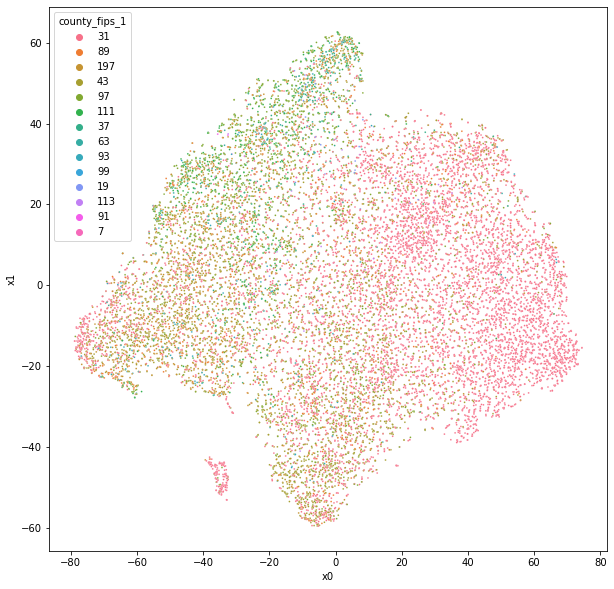

In [146]:
# SW: Latent space relates to counties?
Y_df['county_fips_1'] = Y_df['county_fips_1'].astype('str')
plt.subplots(figsize = (10, 10))
sns.scatterplot(data = Y_df, x="x0", y="x1", hue = 'county_fips_1', s = 3)

# sns.kdeplot(data=Y_df, x='x0', y='x1', hue = 'county_fips_1')

In [106]:
# SW: Add the 11 digit census tract IDs to Y_df.
census_tract_11d_list = []

for i in range(Y_df.shape[0]):
    state = str(Y_df.loc[i, 'state_fips_1'])
    county = str(Y_df.loc[i, 'county_fips_1'])
    tract = str(Y_df.loc[i, 'tract_fips_1'])
    if len(county) < 3:
        county = '0'*(3 - len(county)) + county        
    if len(tract) < 6:
        tract = '0'*(6 - len(tract)) + tract
    census_tract_11d = state + county + tract
    census_tract_11d_list.append(census_tract_11d)

Y_df['census_tract_11d'] = census_tract_11d_list
Y_df

x0         x1 census_tract_y   census_tract  tot_population  \
0      47.861042  35.246555   17_31_823302   17_31_823302          0.5979   
1      -2.249317 -17.083941   17_89_852905   17_89_852905          0.4522   
2     -12.401425  33.111824  17_197_880113  17_197_880113          0.3780   
3       7.471601 -34.985386   17_43_840202   17_43_840202          0.5839   
4      -2.544742   2.280747   17_31_804714   17_31_804714          0.3227   
...          ...        ...            ...            ...             ...   
17305  48.569759 -13.173395  17_111_870812  17_111_870812          0.4580   
17306   3.309313  54.440861  17_111_870812  17_111_870812          0.4580   
17307 -10.557844 -20.130695  17_111_870812  17_111_870812          0.4580   
17308  25.389475 -10.776248  17_111_870812  17_111_870812          0.4580   
17309  25.587831 -31.361269  17_111_870812  17_111_870812          0.4580   

       pct25_34yrs  pct35_50yrs  pctover65yrs  pctwhite_alone  pct_nonwhite  \
0         0.161064     0.155544      0.128282        0.532698      0.467302   
1         0.099071     0.235958      0.111676        0.509288      0.490712   
2         0.161905     0.199206      0.064021        0.311376      0.688624   
3         0.113889     0.146600      0.222127        0.881144      0.118856   
4         0.121475     0.259374      0.141927        0.747134      0.252866   
...            ...          ...           ...             ...           ...   
17305     0.104148     0.254585      0.084279        0.930568      0.069432   
17306     0.104148     0.254585      0.084279        0.930568      0.069432   
17307     0.104148     0.254585      0.084279        0.930568      0.069432   
17308     0.104148     0.254585      0.084279        0.930568      0.069432   
17309     0.104148     0.254585      0.084279        0.930568      0.069432   

       ...  inc_per_capita  state_1  state_fips_1  county_fips_1  \
0      ...        0.154593       IL            17             31   
1      ...        0.109373       IL            17             89   
2      ...        0.128963       IL            17            197   
3      ...        0.227644       IL            17             43   
4      ...        0.224752       IL            17             31   
...    ...             ...      ...           ...            ...   
17305  ...        0.219916       IL            17            111   
17306  ...        0.219916       IL            17            111   
17307  ...        0.219916       IL            17            111   
17308  ...        0.219916       IL            17            111   
17309  ...        0.219916       IL            17            111   

       tract_fips_1  mode  wtperfin_mode  wtperfin_all  mode_share  \
0            823302     2      6497.3341     7177.2929    0.905262   
1            852905     2      9887.9204    10483.9920    0.943145   
2            880113     2      9321.6444     9381.4312    0.993627   
3            840202     2      6880.2732     6880.2732    1.000000   
4            804714     2      6671.2959     7842.8961    0.850616   
...             ...   ...            ...           ...         ...   
17305        870812     2      6430.6895     7360.7037    0.873651   
17306        870812     2      6430.6895     7360.7037    0.873651   
17307        870812     2      6430.6895     7360.7037    0.873651   
17308        870812     2      6430.6895     7360.7037    0.873651   
17309        870812     2      6430.6895     7360.7037    0.873651   

       census_tract_11d  
0           17031823302  
1           17089852905  
2           17197880113  
3           17043840202  
4           17031804714  
...                 ...  
17305       17111870812  
17306       17111870812  
17307       17111870812  
17308       17111870812  
17309       17111870812  

[17310 rows x 32 columns]

In [95]:
len(np.unique(Y_df['census_tract']))

925

In [118]:
Y_df['census_tract_11d']

0        17031823302
1        17089852905
2        17197880113
3        17043840202
4        17031804714
            ...     
17305    17111870812
17306    17111870812
17307    17111870812
17308    17111870812
17309    17111870812
Name: census_tract_11d, Length: 17310, dtype: object

In [117]:
ct_shp['GEOID10']

0      17031010100
1      17031010201
2      17031010202
3      17031010300
4      17031010400
          ...     
806    17031843700
807    17031843800
808    17031843900
809    17031980000
810    17031980100
Name: GEOID10, Length: 811, dtype: object

In [113]:
# SW get the spatial info. 

import geopandas as gpd

ct_shp = gpd.read_file('/home/jtl/Dropbox (MIT)/project_image_demand/data/CTA shapefiles/census_tracts.shp')
ct_shp['GEOID10'] = ct_shp['GEOID10'].astype('str')
ct_shp['geo_x'] = ct_shp.centroid.map(lambda p: p.x)
ct_shp['geo_y'] = ct_shp.centroid.map(lambda p: p.y)

ct_shp['geo_x'] = (ct_shp['geo_x'] - min(ct_shp['geo_x']))/(max(ct_shp['geo_x']) - min(ct_shp['geo_x']))
ct_shp['geo_y'] = (ct_shp['geo_y'] - min(ct_shp['geo_y']))/(max(ct_shp['geo_y']) - min(ct_shp['geo_y']))
ct_shp


STATEFP10  COUNTYFP10  TRACTCE10      GEOID10          area  \
0           17          31      10100  17031010100  3.807865e+05   
1           17          31      10201  17031010201  5.041069e+05   
2           17          31      10202  17031010202  3.514654e+05   
3           17          31      10300  17031010300  4.716770e+05   
4           17          31      10400  17031010400  5.483579e+05   
..         ...         ...        ...          ...           ...   
806         17          31     843700  17031843700  1.262161e+06   
807         17          31     843800  17031843800  1.308558e+06   
808         17          31     843900  17031843900  1.628744e+06   
809         17          31     980000  17031980000  1.908205e+07   
810         17          31     980100  17031980100  2.959233e+06   

                                              geometry     geo_x     geo_y  
0    POLYGON ((444793.217 4652127.132, 444710.741 4...  0.659091  1.000000  
1    POLYGON ((443501.145 4651389.481, 443472.740 4...  0.633279  0.986017  
2    POLYGON ((444205.506 4651400.335, 444176.685 4...  0.650290  0.986024  
3    POLYGON ((444686.507 4651407.891, 444650.564 4...  0.667196  0.985622  
4    POLYGON ((445348.719 4649786.620, 445337.620 4...  0.685302  0.955809  
..                                                 ...       ...       ...  
806  POLYGON ((443369.625 4642881.821, 443369.878 4...  0.604853  0.794541  
807  POLYGON ((447004.316 4627149.483, 446963.264 4...  0.726780  0.408296  
808  POLYGON ((452634.803 4624382.914, 452607.621 4...  0.878448  0.338909  
809  POLYGON ((425970.565 4645133.223, 425971.810 4...  0.074705  0.892918  
810  POLYGON ((437303.853 4625424.848, 437242.341 4...  0.450115  0.367919  

[811 rows x 8 columns]

In [120]:
# SW: concat Y_df and ct_shp
Y_df_cook = Y_df.merge(ct_shp, left_on = 'census_tract_11d', right_on = 'GEOID10', how = 'inner').reset_index()
Y_df_cook

index         x0         x1 census_tract_y  census_tract  \
0         0  56.210323  -0.703168    17_31_50100   17_31_50100   
1         1  35.057457 -25.171328    17_31_50100   17_31_50100   
2         2  61.029205 -23.865707    17_31_50100   17_31_50100   
3         3  58.509563  10.842164    17_31_50100   17_31_50100   
4         4  55.891174 -28.549658    17_31_50100   17_31_50100   
...     ...        ...        ...            ...           ...   
4525   4525  54.255032  24.988926   17_31_431400  17_31_431400   
4526   4526  14.876582   3.720470   17_31_431400  17_31_431400   
4527   4527 -13.502894 -18.320967   17_31_431400  17_31_431400   
4528   4528 -13.485378 -18.326672   17_31_431400  17_31_431400   
4529   4529  23.137726  -1.831308   17_31_431400  17_31_431400   

      tot_population  pct25_34yrs  pct35_50yrs  pctover65yrs  pctwhite_alone  \
0             0.2731     0.285244     0.289271      0.064811        0.818382   
1             0.2731     0.285244     0.289271      0.064811        0.818382   
2             0.2731     0.285244     0.289271      0.064811        0.818382   
3             0.2731     0.285244     0.289271      0.064811        0.818382   
4             0.2731     0.285244     0.289271      0.064811        0.818382   
...              ...          ...          ...           ...             ...   
4525          0.6979     0.134976     0.204041      0.136123        0.077948   
4526          0.6979     0.134976     0.204041      0.136123        0.077948   
4527          0.6979     0.134976     0.204041      0.136123        0.077948   
4528          0.6979     0.134976     0.204041      0.136123        0.077948   
4529          0.6979     0.134976     0.204041      0.136123        0.077948   

      ...  mode_share  census_tract_11d  STATEFP10  COUNTYFP10  TRACTCE10  \
0     ...    0.412902       17031050100         17          31      50100   
1     ...    0.412902       17031050100         17          31      50100   
2     ...    0.412902       17031050100         17          31      50100   
3     ...    0.412902       17031050100         17          31      50100   
4     ...    0.412902       17031050100         17          31      50100   
...   ...         ...               ...        ...         ...        ...   
4525  ...    0.692685       17031431400         17          31     431400   
4526  ...    0.692685       17031431400         17          31     431400   
4527  ...    0.692685       17031431400         17          31     431400   
4528  ...    0.692685       17031431400         17          31     431400   
4529  ...    0.692685       17031431400         17          31     431400   

          GEOID10          area  \
0     17031050100  3.343938e+05   
1     17031050100  3.343938e+05   
2     17031050100  3.343938e+05   
3     17031050100  3.343938e+05   
4     17031050100  3.343938e+05   
...           ...           ...   
4525  17031431400  1.077924e+06   
4526  17031431400  1.077924e+06   
4527  17031431400  1.077924e+06   
4528  17031431400  1.077924e+06   
4529  17031431400  1.077924e+06   

                                               geometry     geo_x     geo_y  
0     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
1     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
2     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
3     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
4     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
...                                                 ...       ...       ...  
4525  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4526  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4527  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4528  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4529  POLYGON ((454193.469 4622464.384, 454172.2

In [112]:
normalize(ct_shp[['geo_x', 'geo_y']], axis = 0)


array([[0.03518676, 0.0352504 ],
       [0.03511886, 0.03524603],
       [0.03516361, 0.03524603],
       ...,
       [0.03576373, 0.03504383],
       [0.03364964, 0.03521694],
       [0.03463708, 0.0350529 ]])

STATEFP10  COUNTYFP10  TRACTCE10      GEOID10          area  \
0           17          31      10100  17031010100  3.807865e+05   
1           17          31      10201  17031010201  5.041069e+05   
2           17          31      10202  17031010202  3.514654e+05   
3           17          31      10300  17031010300  4.716770e+05   
4           17          31      10400  17031010400  5.483579e+05   
..         ...         ...        ...          ...           ...   
806         17          31     843700  17031843700  1.262161e+06   
807         17          31     843800  17031843800  1.308558e+06   
808         17          31     843900  17031843900  1.628744e+06   
809         17          31     980000  17031980000  1.908205e+07   
810         17          31     980100  17031980100  2.959233e+06   

                                              geometry          geo_x  \
0    POLYGON ((444793.217 4652127.132, 444710.741 4...  444543.436274   
1    POLYGON ((443501.145 4651389.481, 443472.740 4...  443685.695951   
2    POLYGON ((444205.506 4651400.335, 444176.685 4...  444250.985084   
3    POLYGON ((444686.507 4651407.891, 444650.564 4...  444812.797628   
4    POLYGON ((445348.719 4649786.620, 445337.620 4...  445414.472742   
..                                                 ...            ...   
806  POLYGON ((443369.625 4642881.821, 443369.878 4...  442741.067866   
807  POLYGON ((447004.316 4627149.483, 446963.264 4...  446792.811284   
808  POLYGON ((452634.803 4624382.914, 452607.621 4...  451832.876017   
809  POLYGON ((425970.565 4645133.223, 425971.810 4...  425123.793107   
810  POLYGON ((437303.853 4625424.848, 437242.341 4...  437598.990812   

            geo_y  
0    4.652354e+06  
1    4.651777e+06  
2    4.651778e+06  
3    4.651761e+06  
4    4.650532e+06  
..            ...  
806  4.643881e+06  
807  4.627953e+06  
808  4.625092e+06  
809  4.647938e+06  
810  4.626288e+06  

[811 rows x 8 columns]

In [ ]:
def visualize_contourf(zoom = True):
    def f(x, y):
        return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)
    x = np.linspace(0, 5, 200)
    y = np.linspace(0, 5, 200)
    X, Y = np.meshgrid(x, y); Z=f(X,Y)
    
    fig, ax = plt.subplots(figsize = (8, 8))
    if zoom == True:
        zoom_in_constant = 2
        # interpolate the data to make the visualization smooth
        X = scipy.ndimage.zoom(X, zoom_in_constant)
        Y = scipy.ndimage.zoom(Y, zoom_in_constant)
        Z = scipy.ndimage.zoom(Z, zoom_in_constant)    
    contours = ax.contourf(X, Y, Z, 5, cmap='Blues', vmin = -1, vmax = 1)
    plt.clabel(contours, inline=True, fontsize=8)
    plt.colorbar(contours)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    fig.suptitle("X and P", fontsize = 20)

In [49]:
Y_df.columns

Index(['x0', 'x1', 'census_tract_y', 'census_tract', 'tot_population',
       'pct25_34yrs', 'pct35_50yrs', 'pctover65yrs', 'pctwhite_alone',
       'pct_nonwhite', 'pctblack_alone', 'pct_col_grad', 'pctPTcommute',
       '25_34yrs', '35_50yrs', 'over65yrs', 'white_alone', 'nonwhite',
       'black_alone', 'col_grad', 'PTcommute', 'avg_tt_to_work',
       'inc_per_capita', 'state_1', 'state_fips_1', 'county_fips_1',
       'tract_fips_1', 'mode', 'wtperfin_mode', 'wtperfin_all', 'mode_share'],
      dtype='object')

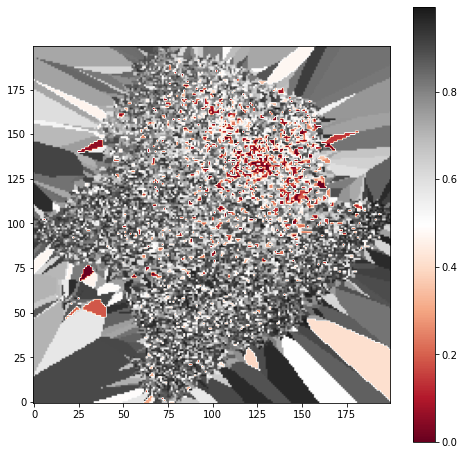

In [89]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[min(Y_df['x0']):max(Y_df['x0']):200j, min(Y_df['x1']):max(Y_df['x1']):200j]
# grid_x.shape

grid_z0 = griddata(Y_df[['x0', 'x1']], Y_df['pctwhite_alone'], (grid_x, grid_y), method='nearest')



fig, ax = plt.subplots(figsize = (8, 8))
# contours = ax.imshow(grid_x, grid_y, grid_z0, 5, cmap='Blues')
# plt.clabel(contours, inline=True, fontsize=8)
# plt.colorbar(contours)

# plt.contour(grid_x, grid_y, grid_z0, colors='black')

cax1 = ax.imshow(grid_z0, origin='lower',
           cmap='RdGy')
plt.colorbar(cax1)

ax.imshow(grid_z0, origin='lower', cmap='RdGy')




In [87]:
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi)
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

X_mesh, Y_mesh, Z_mesh = grid(Y_df['x0'], Y_df['x1'], Y_df['pctwhite_alone'])
plt.scatter(X_mesh, Y_mesh, Z_mesh)



ImportError: cannot import name 'griddata' from 'matplotlib.mlab' (/home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mlab.py)

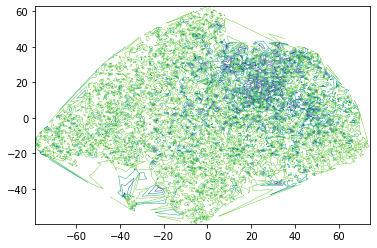

In [60]:
plt.tricontour(Y_df['x0'], Y_df['x1'], Y_df['pctwhite_alone'], 5, linewidths=0.5)

In [25]:
# Plot X and Y. 
x = Y_df['x0']
y = Y_df['x1']
X_mesh, Y_mesh = np.meshgrid(x, y)
Z = 




In [123]:
Y_df_cook

index         x0         x1 census_tract_y  census_tract  \
0         0  56.210323  -0.703168    17_31_50100   17_31_50100   
1         1  35.057457 -25.171328    17_31_50100   17_31_50100   
2         2  61.029205 -23.865707    17_31_50100   17_31_50100   
3         3  58.509563  10.842164    17_31_50100   17_31_50100   
4         4  55.891174 -28.549658    17_31_50100   17_31_50100   
...     ...        ...        ...            ...           ...   
4525   4525  54.255032  24.988926   17_31_431400  17_31_431400   
4526   4526  14.876582   3.720470   17_31_431400  17_31_431400   
4527   4527 -13.502894 -18.320967   17_31_431400  17_31_431400   
4528   4528 -13.485378 -18.326672   17_31_431400  17_31_431400   
4529   4529  23.137726  -1.831308   17_31_431400  17_31_431400   

      tot_population  pct25_34yrs  pct35_50yrs  pctover65yrs  pctwhite_alone  \
0             0.2731     0.285244     0.289271      0.064811        0.818382   
1             0.2731     0.285244     0.289271      0.064811        0.818382   
2             0.2731     0.285244     0.289271      0.064811        0.818382   
3             0.2731     0.285244     0.289271      0.064811        0.818382   
4             0.2731     0.285244     0.289271      0.064811        0.818382   
...              ...          ...          ...           ...             ...   
4525          0.6979     0.134976     0.204041      0.136123        0.077948   
4526          0.6979     0.134976     0.204041      0.136123        0.077948   
4527          0.6979     0.134976     0.204041      0.136123        0.077948   
4528          0.6979     0.134976     0.204041      0.136123        0.077948   
4529          0.6979     0.134976     0.204041      0.136123        0.077948   

      ...  mode_share  census_tract_11d  STATEFP10  COUNTYFP10  TRACTCE10  \
0     ...    0.412902       17031050100         17          31      50100   
1     ...    0.412902       17031050100         17          31      50100   
2     ...    0.412902       17031050100         17          31      50100   
3     ...    0.412902       17031050100         17          31      50100   
4     ...    0.412902       17031050100         17          31      50100   
...   ...         ...               ...        ...         ...        ...   
4525  ...    0.692685       17031431400         17          31     431400   
4526  ...    0.692685       17031431400         17          31     431400   
4527  ...    0.692685       17031431400         17          31     431400   
4528  ...    0.692685       17031431400         17          31     431400   
4529  ...    0.692685       17031431400         17          31     431400   

          GEOID10          area  \
0     17031050100  3.343938e+05   
1     17031050100  3.343938e+05   
2     17031050100  3.343938e+05   
3     17031050100  3.343938e+05   
4     17031050100  3.343938e+05   
...           ...           ...   
4525  17031431400  1.077924e+06   
4526  17031431400  1.077924e+06   
4527  17031431400  1.077924e+06   
4528  17031431400  1.077924e+06   
4529  17031431400  1.077924e+06   

                                               geometry     geo_x     geo_y  
0     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
1     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
2     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
3     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
4     POLYGON ((443821.010 4644910.301, 443787.025 4...  0.641151  0.829361  
...                                                 ...       ...       ...  
4525  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4526  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4527  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4528  POLYGON ((454193.469 4622464.384, 454172.243 4...  0.946102  0.289649  
4529  POLYGON ((454193.469 4622464.384, 454172.2

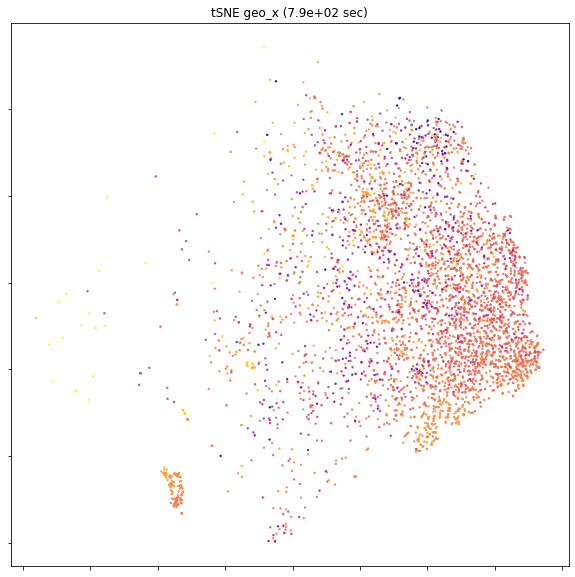

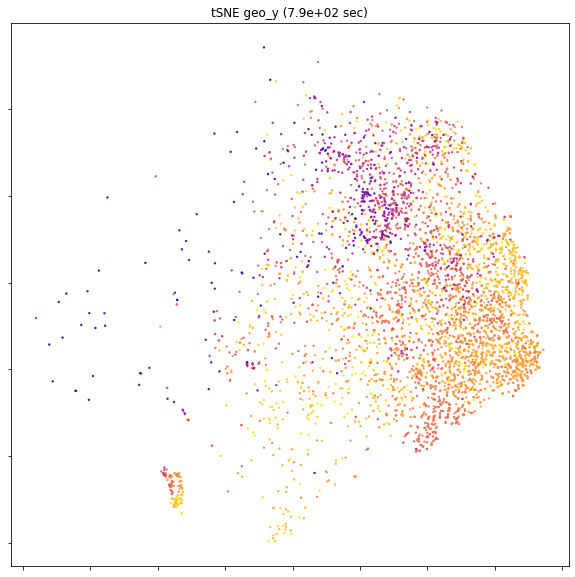

In [151]:
# SW. Check the space info mapping to the latent space
for c in ['geo_x', 'geo_y']:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.scatter(Y_df_cook['x0'], Y_df_cook['x1'], c=Y_df_cook[c], s=2, cmap=plt.cm.plasma, alpha=0.8)
    ax.set_title("%s (%.2g sec)" % ('tSNE '+c, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight');


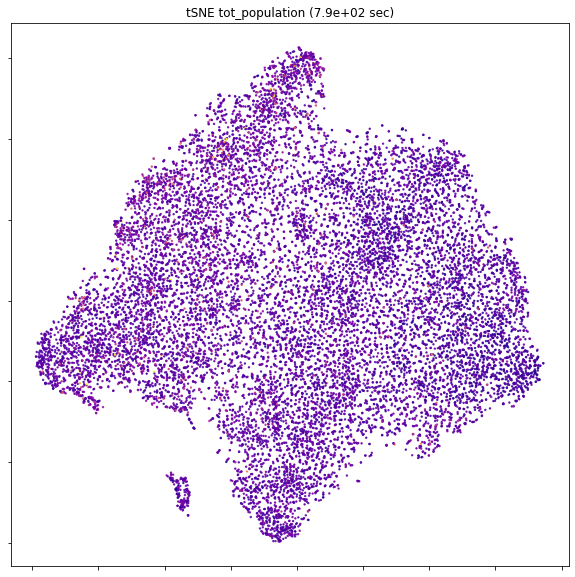

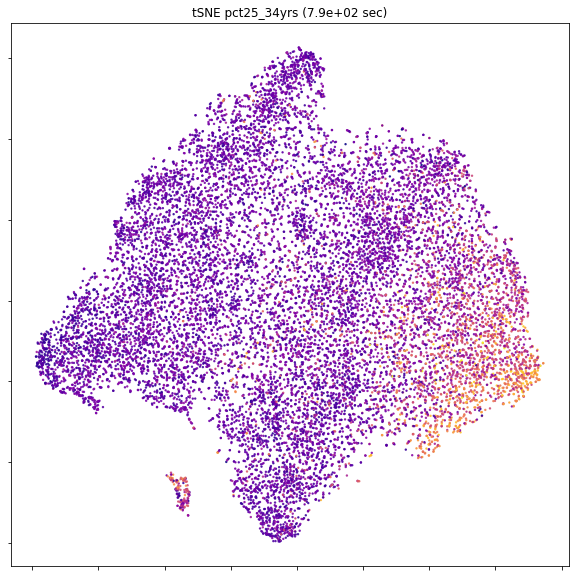

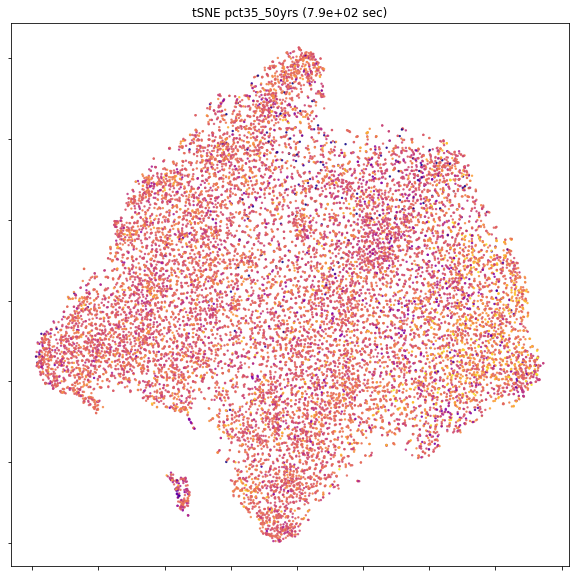

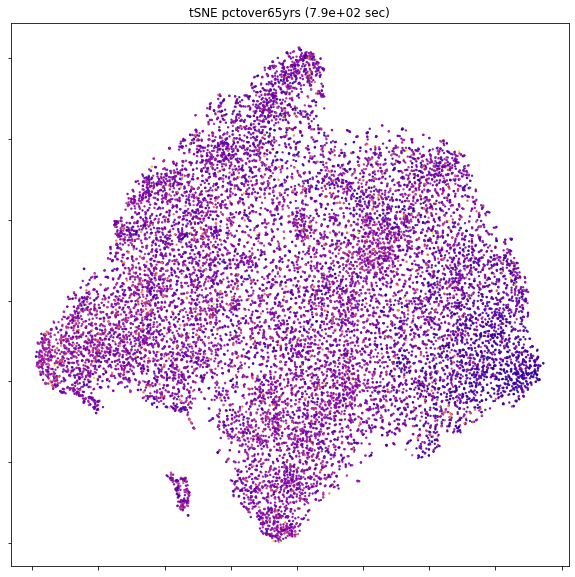

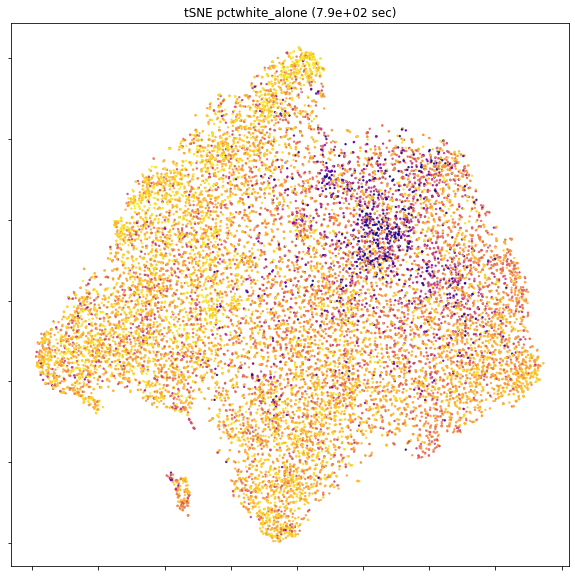

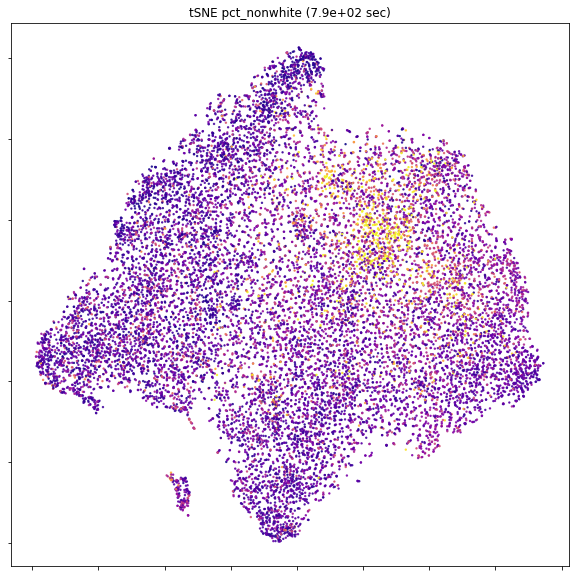

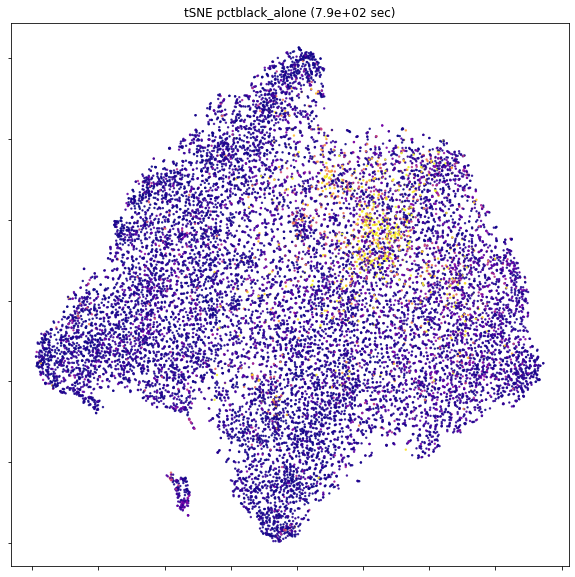

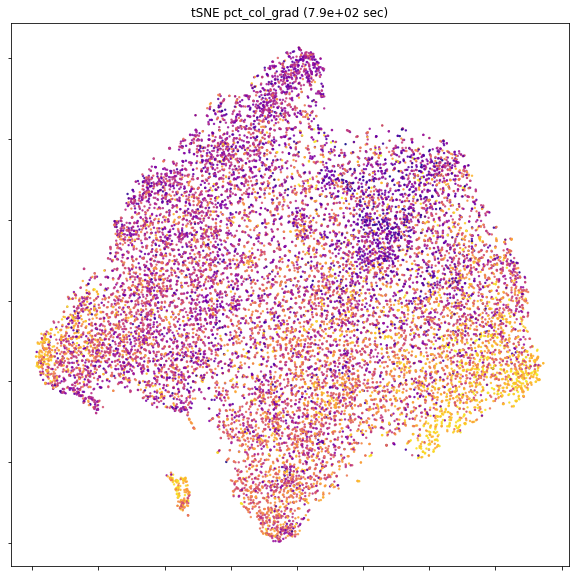

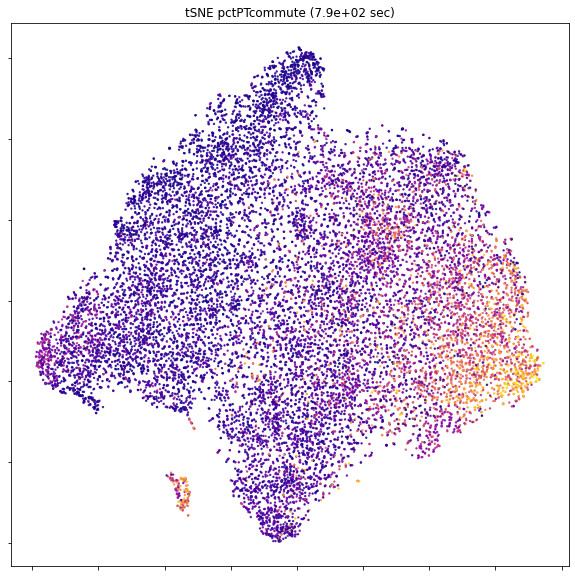

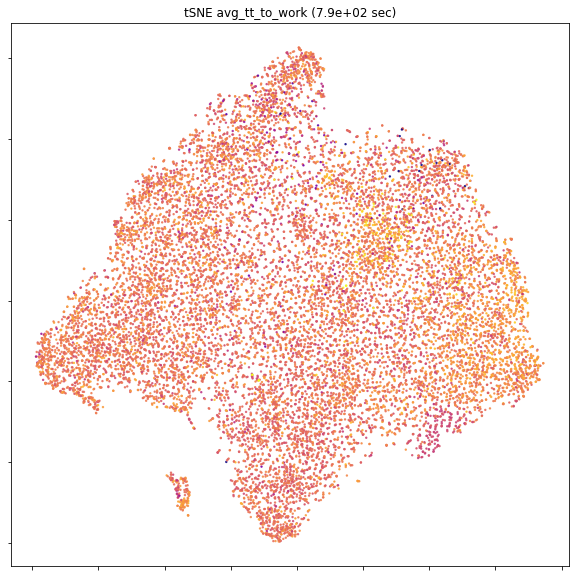

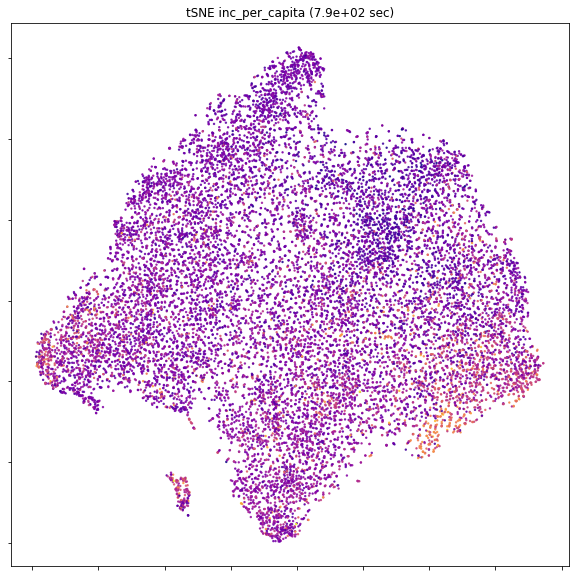

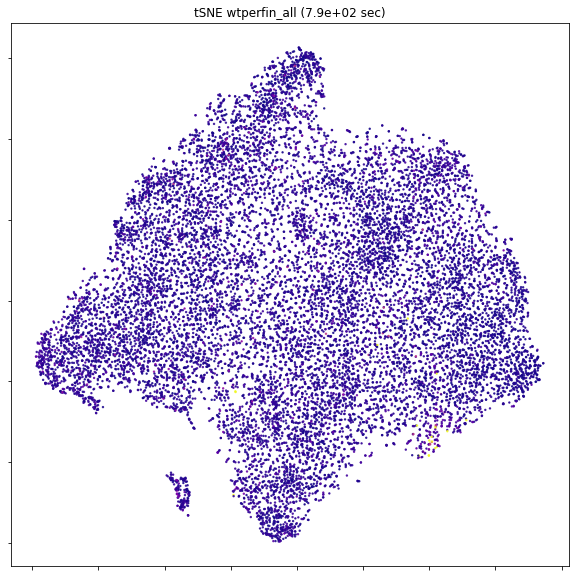

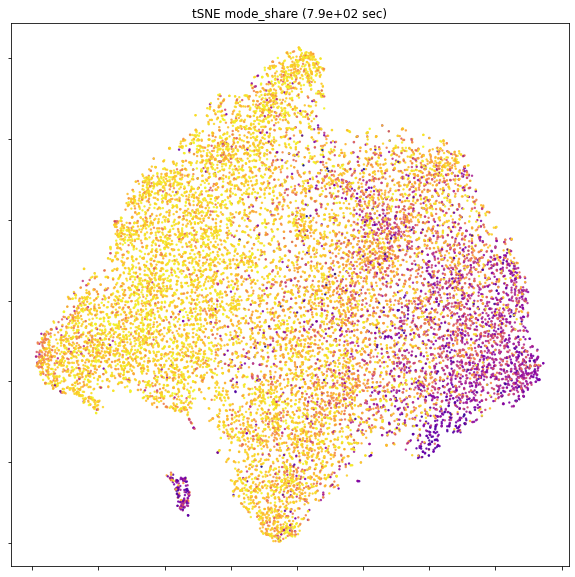

In [152]:
for c in ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','pctPTcommute', 'avg_tt_to_work','inc_per_capita', 
         'wtperfin_all', 'mode_share']:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.scatter(Y[:, 0], Y[:, 1], c=ct_df[c], s=2, cmap=plt.cm.plasma, alpha=0.8)
    ax.set_title("%s (%.2g sec)" % ('tSNE '+c, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight');
    

In [ ]:
# 